## Decision Tree Hyperparameter Optimization
This notebook is part of a project to identify sentence complexity and includes all engineered features including LSA/K-means on Tfidf results and Word2Vec principal components and clusters.  The notebook includes the following:

- Load Data
- Run Baseline Decision Tree Model
    - Generate F1 Scores
    - Generate Confusion Matrix
    - Generate Feature Importance Scores (via MDI)
    - Generate Feature Importance Socres (via permutation)
    - Show Initial Decision Tree Models in Ensemble 
- Use GridSeachCV to Optimize Decision Tree Hyperparameters
    - Generate F1 Scores
    - Generate Confusion Matrix
    - Generate Feature Importance Scores (via MDI)
    - Generate Feature Importance Scores (via permutation)
    - Full Results from GridSearchCV

In [1]:
#import needed libraries
import gzip
import pandas as pd
import numpy as np
from numpy import nan

import matplotlib.pyplot as plt 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.inspection import permutation_importance
from sklearn import tree

from tqdm import tqdm
import time
import sys
import os

#set random seed for consistency
RANDOM_SEED = 694

## Load Data

In [2]:
#load data prepared from feature engineering
df_train=pd.read_csv('Train_Data_Final.csv')
df_test=pd.read_csv('Test_Data_Final.csv')
df_dev=pd.read_csv('Dev_Data_Final.csv')

In [3]:
#get data discovered using LSA/K-means
df_train_lsa=pd.read_csv('Train_LSA_Kmeans.csv')
df_test_lsa=pd.read_csv('Test_LSA_Kmeans.csv')
df_dev_lsa=pd.read_csv('Dev_LSA_Kmeans.csv')

#get data discovered using Word2Vec
df_train_w2v=pd.read_csv('Train_Word2Vec.csv')
df_test_w2v=pd.read_csv('Test_Word2Vec.csv')
df_dev_w2v=pd.read_csv('Dev_Word2Vec.csv')

In [4]:
#add features to dataframes
lsa_cols = df_train_lsa.columns[3:]
w2v_cols = df_train_w2v.columns[3:]

#add LSA/K-means feature
df_train[lsa_cols] = df_train_lsa[lsa_cols]
df_test[lsa_cols] = df_test_lsa[lsa_cols]
df_dev[lsa_cols] = df_dev_lsa[lsa_cols]

#add Word2Vec feature
df_train[w2v_cols] = df_train_w2v[w2v_cols]
df_test[w2v_cols] = df_test_w2v[w2v_cols]
df_dev[w2v_cols] = df_dev_w2v[w2v_cols]

## Set Train/Test Data

In [5]:
#remove index and data label
X_train=df_train.drop(columns=['Unnamed: 0','label'])._get_numeric_data()
X_test=df_test.drop(columns=['Unnamed: 0','label'])._get_numeric_data()
X_dev=df_dev.drop(columns=['Unnamed: 0','label'])._get_numeric_data()

In [6]:
#correct for infinity and nan 
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train=X_train.fillna(-1)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test=X_test.fillna(-1)
X_dev.replace([np.inf, -np.inf], np.nan, inplace=True)
X_dev=X_dev.fillna(-1)

In [7]:
#assign labels
y_train = df_train['label']
y_test = df_test['label']
y_dev = df_dev['label']

## Decision Tree

In [15]:
%%time
#train model with default parameters (max depth at 10)
dt_clf=DecisionTreeClassifier(max_depth = 10, random_state=RANDOM_SEED)
dt_clf.fit(X_train,y_train)

CPU times: user 51.4 s, sys: 160 ms, total: 51.5 s
Wall time: 51.5 s


DecisionTreeClassifier(max_depth=10, random_state=694)

In [16]:
#check parameters
dt_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 694,
 'splitter': 'best'}

In [17]:
#evaluate model metrics
f1_train=f1_score(y_train,dt_clf.predict(X_train))
f1_test=f1_score(y_test,dt_clf.predict(X_test))
f1_dev=f1_score(y_dev,dt_clf.predict(X_dev))
print('f1_train:',f1_train)
print('f1_test:',f1_test)
print('f1_dev:',f1_dev)

#previous scores without supplemental features (LSA, K-means, Word2Vec)
#f1_train: 0.7416327093998115
#f1_test: 0.7132636213538801
#f1_dev: 0.7198433358011128

f1_train: 0.7511366921601095
f1_test: 0.71819623204626
f1_dev: 0.7263683904706565


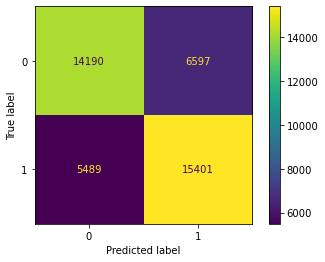

In [18]:
#show confusion matrix
cm=confusion_matrix(y_test, dt_clf.predict(X_test),labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_clf.classes_)
disp.plot()

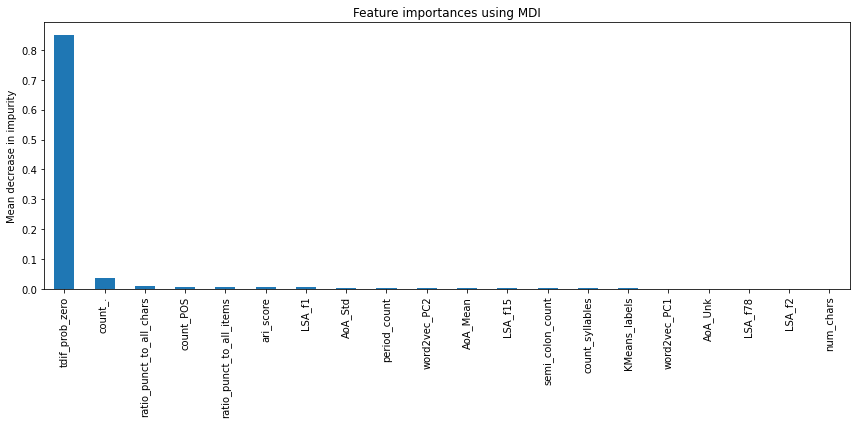

In [19]:
#examine feature importance using mean decrease in impurity
feature_names = list(X_train.columns)
dt_clf.feature_importances_

importances= pd.Series(dt_clf.feature_importances_, index=feature_names)

fig, ax = plt.subplots(figsize=(12,6))

importances.sort_values(ascending=False)[0:20].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [20]:
%%time
#examine permutation importance
result = permutation_importance(dt_clf, X_dev, y_dev, n_repeats=10, random_state=RANDOM_SEED)
forest_importances = pd.Series(result.importances_mean, index=[X_dev.columns])

CPU times: user 1min 9s, sys: 34 s, total: 1min 43s
Wall time: 1min 43s


In [21]:
#sort by most important features
top_sorted_forest_importances = forest_importances.sort_values(axis=0, ascending=False)

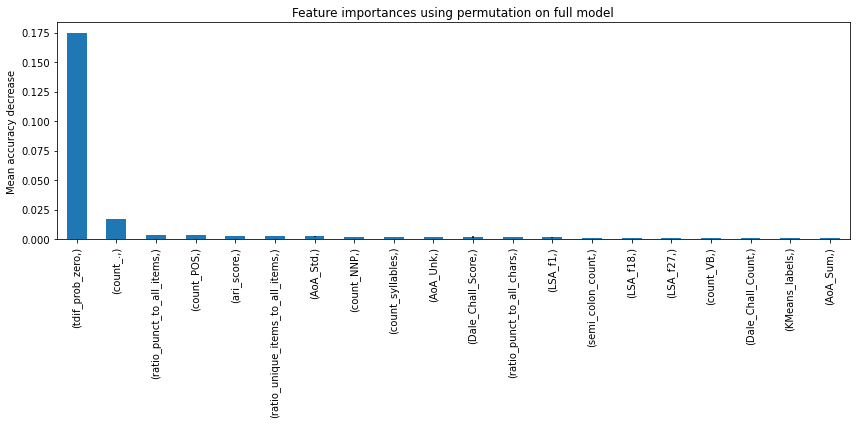

In [22]:
#plot results
fig, ax = plt.subplots(figsize=(12,6))
top_sorted_forest_importances[0:20].plot.bar(yerr=result.importances_std[0:20], ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

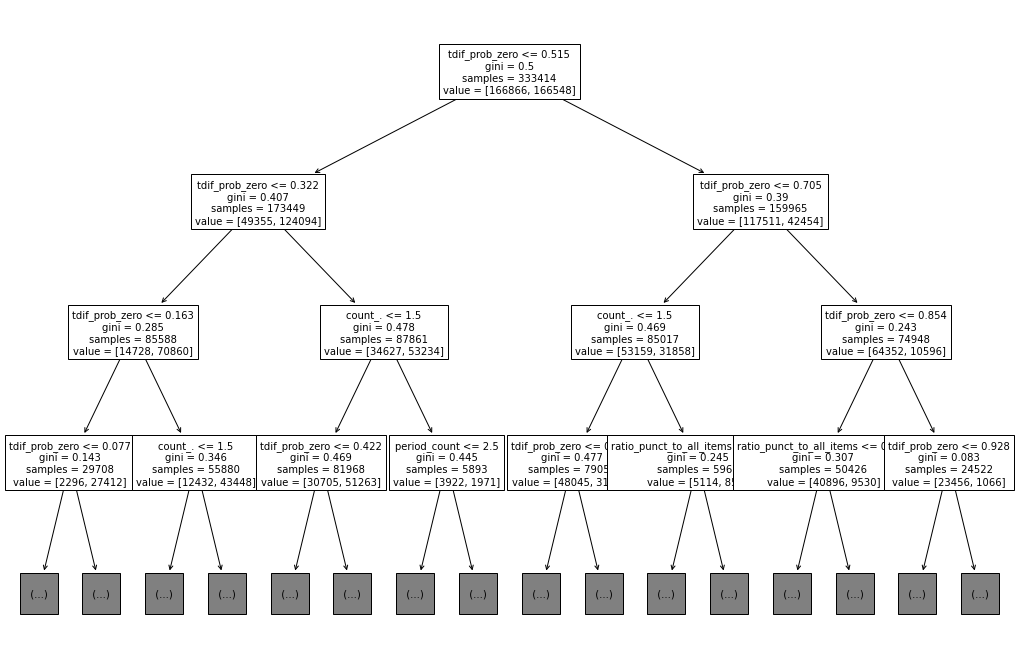

In [23]:
#plot first layers of the decision tree
plt.figure(figsize=(18,12)) 
tree.plot_tree(dt_clf, feature_names=X_dev.columns, fontsize=10, max_depth=3)
plt.show()

## Decision Tree Hyperparamter Tuning

In [24]:
#show current paramters being used
dt_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 694,
 'splitter': 'best'}

In [25]:
#create grid parameters
max_features = ['auto', 'sqrt']
criterion = ['gini', 'entropy']
max_features = ['auto']
criterion = ['gini']
splitter = ['best', 'random']
max_depth = [6, 8, 10, 12]
min_samples_split = [2, 4, 6, 8]
min_samples_leaf = [1, 2, 3]

In [26]:
#set parameters for grid search
dt_params = {'max_features': max_features,
               'criterion': criterion,
               'splitter': splitter,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }
dt_params

{'max_features': ['auto'],
 'criterion': ['gini'],
 'splitter': ['best', 'random'],
 'max_depth': [6, 8, 10, 12],
 'min_samples_split': [2, 4, 6, 8],
 'min_samples_leaf': [1, 2, 3]}

In [31]:
#new decision tree
dt = DecisionTreeClassifier(random_state = RANDOM_SEED)

In [32]:
%%time
#fit model using GridSearchCV
dt_grid = GridSearchCV(estimator=dt, param_grid=dt_params, n_jobs=-1, cv=3, verbose=2, scoring = "accuracy")
dt_grid.fit(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
CPU times: user 4.29 s, sys: 626 ms, total: 4.91 s
Wall time: 2min 23s


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=694),
             n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [6, 8, 10, 12],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 6, 8],
                         'splitter': ['best', 'random']},
             scoring='accuracy', verbose=2)

In [33]:
#show parameters with best results
dt_grid.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 694,
 'splitter': 'best'}

In [34]:
#check f1 scores
f1_train_grid=f1_score(y_train,dt_grid.predict(X_train))
f1_test_grid=f1_score(y_test,dt_grid.predict(X_test))
f1_dev_grid=f1_score(y_dev,dt_grid.predict(X_dev))
print('f1_train_rand:',f1_train_grid)
print('f1_test_rand:',f1_test_grid)
print('f1_dev_rand:',f1_dev_grid)

f1_train_rand: 0.7347259645784793
f1_test_rand: 0.7134906753288054
f1_dev_rand: 0.7176521285523122


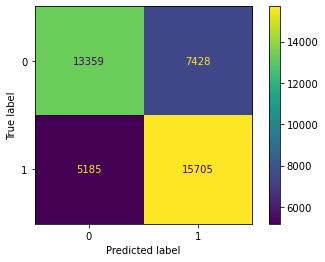

In [35]:
#plot confusion matrix
cm=confusion_matrix(y_test, dt_grid.predict(X_test),labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_grid.classes_)
disp.plot()

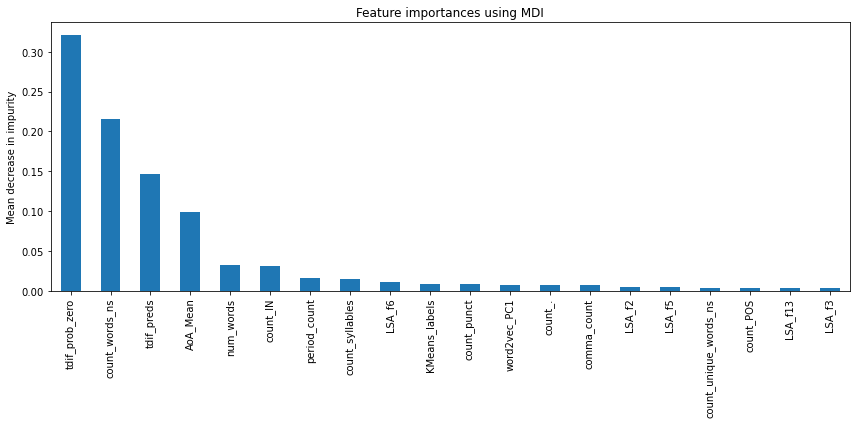

In [48]:
#feature imporance with MDI
feature_names = list(X_train.columns)

importances= pd.Series(dt_grid.best_estimator_.feature_importances_, index=feature_names)

fig, ax = plt.subplots(figsize=(12,6))

importances.sort_values(ascending=False)[0:20].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [37]:
%%time
#permutation importance
result = permutation_importance(dt_grid, X_dev, y_dev, n_repeats=10, random_state=RANDOM_SEED)
forest_importances = pd.Series(result.importances_mean, index=[X_dev.columns])

CPU times: user 1min 8s, sys: 33.6 s, total: 1min 41s
Wall time: 1min 41s


In [49]:
top_sorted_forest_importances = forest_importances.sort_values(axis=0, ascending=False)

In [55]:
list(top_sorted_forest_importances.index[0:5])

[('tdif_prob_zero',),
 ('tdif_preds',),
 ('AoA_Mean',),
 ('period_count',),
 ('count_IN',)]

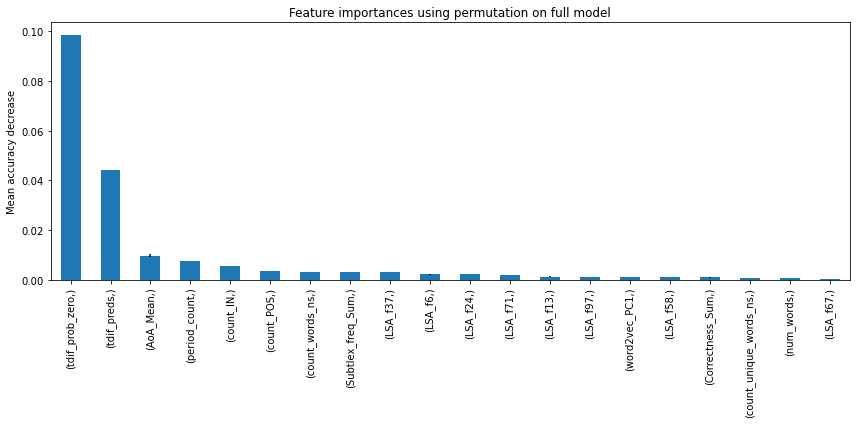

In [39]:
#plot results
fig, ax = plt.subplots(figsize=(12,6))
top_sorted_forest_importances[0:20].plot.bar(yerr=result.importances_std[0:20], ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [40]:
dt_grid.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 694,
 'splitter': 'best'}

In [41]:
%%time
#run model using best parameters
dt_best=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, splitter='best', random_state=RANDOM_SEED)
dt_best.fit(X_train,y_train)

CPU times: user 2.97 s, sys: 212 ms, total: 3.18 s
Wall time: 3.18 s


DecisionTreeClassifier(max_depth=8, max_features='auto', min_samples_split=4,
                       random_state=694)

In [42]:
#confirm metrics
f1_train_best=f1_score(y_train,dt_best.predict(X_train))
f1_test_best=f1_score(y_test,dt_best.predict(X_test))
f1_dev_best=f1_score(y_dev,dt_best.predict(X_dev))
print('f1_train_rand:',f1_train_best)
print('f1_test_rand:',f1_test_best)
print('f1_dev_rand:',f1_dev_best)

f1_train_rand: 0.7347259645784793
f1_test_rand: 0.7134906753288054
f1_dev_rand: 0.7176521285523122


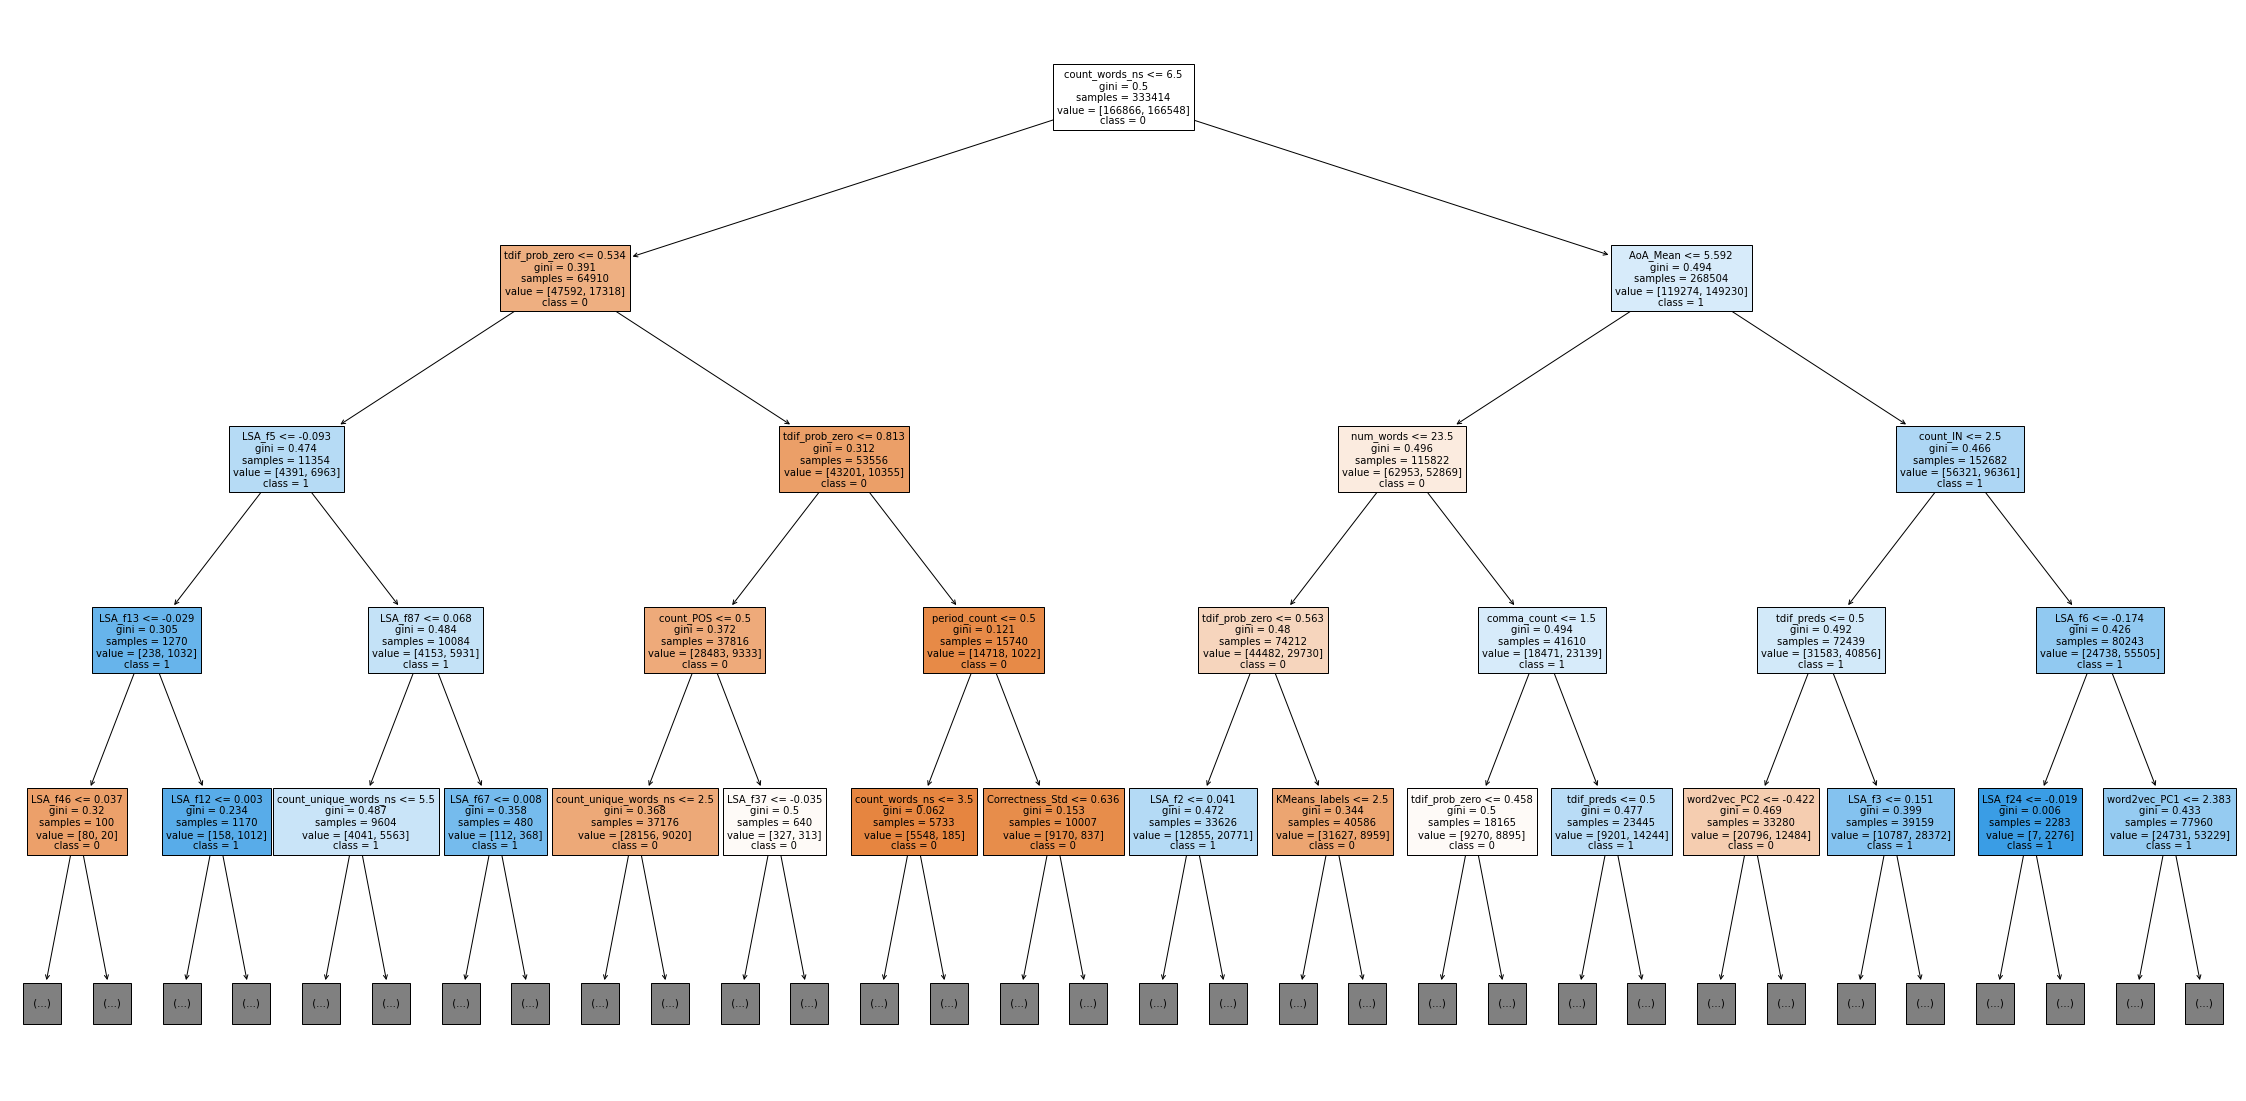

In [64]:
#plot first layers of the decision tree
plt.figure(figsize=(40,20)) 
tree.plot_tree(dt_best, feature_names=X_dev.columns, 
               class_names=['0','1'],fontsize=10, max_depth=4,
               filled=True)
plt.show()